In [1]:
import os
import glob

import pandas as pd
import numpy as np

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from attentionVis import AttentionVis
from model import GPT, GPTConfig
from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
import skimage
import skvideo.io
from utils import print_full

import matplotlib.pyplot as plt
from utils import set_plot_params
set_plot_params()
%matplotlib inline
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"

In [2]:
from utils import set_seed
set_seed(25)

In [3]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset

train_path = parent_path + "code/data/OneCombo3/stimuli/"
video_stack = [skimage.io.imread(vid) for vid in glob.glob(train_path + '/*.tif')][::-1]
print(glob.glob(train_path + '/*.tif')[::-1])
video_stack = np.concatenate(video_stack, axis=0, dtype=np.float32)

video_stack = image_dataset(video_stack)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
video_stack = video_stack.view(3, video_stack.shape[0] // 3, video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

['/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-grating.tif', '/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-Movie2.tif', '/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-Movie3.tif']
im_sack size: torch.Size([5760, 1, 64, 112])


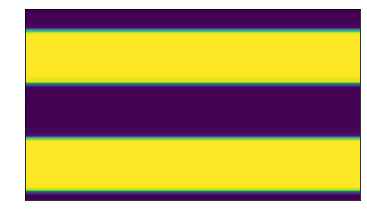

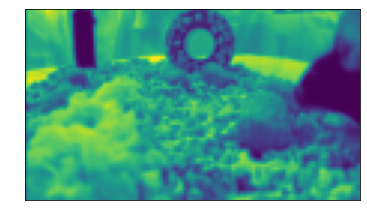

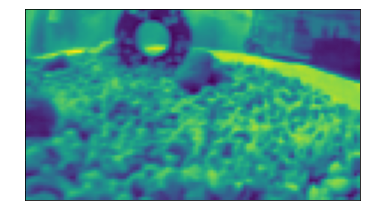

In [4]:
plt.figure()
plt.imshow(video_stack[0, 1].permute(1, 2, 0), cmap='gray')
plt.figure()
plt.imshow(video_stack[1, 1].permute(1, 2, 0), cmap='gray')
plt.figure()
plt.imshow(video_stack[2, 1].permute(1, 2, 0), cmap='gray')

In [5]:
# spike_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A" # "code/data/SImIm/simNeu_3D_WithNorm__Combo3.mat" 
from SpikeVidUtils import trial_df_combo3

spike_data = scipyio.loadmat(parent_path + "code/data/OneCombo3/spiketrain.mat")
spike_data = np.squeeze(spike_data['spiketrain'].T, axis=-1)
spike_data = [trial_df_combo3(spike_data, n_stim) for n_stim in range(3)]
spike_data = pd.concat(spike_data, axis=0)

spike_data['Trial'] = spike_data['Trial'] + 1
spike_data['Time'] = spike_data['Time'] * 0.0751
spike_data = spike_data[(spike_data['Time'] > 0) & (spike_data['Time'] <= 32)]

# vid_duration = [len(vid) * 1/20 for vid in vid_list]

df = spike_data
del spike_data

In [6]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
window = 0.5
dt = 0.01

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['Interval_dt'] = make_intervals(df, dt)
df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(2)
df = df.reset_index(drop=True)

In [7]:
n_dt = sorted((df['Interval_dt'].unique()).round(3)) # add last interval for EOS'

df['Time'] = df['Time'].round(3)

In [8]:
# df.groupby(['Interval', 'Trial']).size().plot.bar()
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
df.groupby(['Interval', 'Trial']).size().nlargest(100)

Interval  Trial
18.5      42       49
4.5       45       36
26.0      49       35
29.0      26       35
4.0       23       33
                   ..
          29       21
          33       21
4.5       22       21
7.0       13       21
7.5       7        21
Length: 100, dtype: int64

In [9]:
from SpikeVidUtils import SpikeTimeVidData

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
frame_feats = video_stack.transpose(1, 2)

frame_block_size = 560
prev_id_block_size = 30
id_block_size = 30 * 2    # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
# pixels = sorted(np.unique(frames).tolist())
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))

0.5

In [10]:
# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)

n = []
for n_stim in range(3):
    n_trial = [3, 15, 5, 18]
    for n_trial in n_trial:
        trial = (n_stim + 1) * 20 - n_trial
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

In [11]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
dataset = SpikeTimeVidData2(df, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
# single_batch = SpikeTimeVidData(df[df['Trial'].isin([5])], None, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats)
small_dataset = SpikeTimeVidData2(small_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)


print(f'train: {len(train_dataset)}')

Length: 20449 Neurons: 168 Pixels: 0.
id block size: 60
frames: 560, id: 60
Length: 25612 Neurons: 168 Pixels: 0.
id block size: 60
frames: 560, id: 60
Length: 393 Neurons: 168 Pixels: 0.
id block size: 60
frames: 560, id: 60
train: 2941


In [12]:
# def get_class_weights(df, population_size):
#     class_freq = df.groupby(['ID']).size().nlargest(2)
#     class_freq_pad = np.array(class_freq.tolist() + [class_freq.max()]*(population_size - len(class_freq)), dtype=np.float32)
#     return torch.tensor(np.reciprocal(class_freq_pad) * class_freq.max(), dtype=torch.float32) / class_freq.max()

def get_class_weights(df, population_size):
    len_data = len(train_data.drop_duplicates(subset=['Interval', 'Trial'])[['Interval', 'Trial']])
    id_freq = [len(df[df['ID'] == id]) for id in range(neurons[-1] + 1)]
    sos_freq = [len_data * 2]
    eos_freq = [len_data * 1]
    pad_freq = [(len_data * (id_block_size + prev_id_block_size)) - len(df)]
    class_freq = np.array(id_freq + sos_freq + eos_freq + pad_freq, dtype=np.float32)
    class_freq = torch.tensor(np.reciprocal(class_freq) * class_freq.max(), dtype=torch.float32) / class_freq.max()
    return torch.nan_to_num(class_freq, 1)

class_weights = get_class_weights(df, train_dataset.id_population_size)

/tmp/ipykernel_8142/156052261.py:13: RuntimeWarning: divide by zero encountered in reciprocal
  class_freq = torch.tensor(np.reciprocal(class_freq) * class_freq.max(), dtype=torch.float32) / class_freq.max()


In [13]:
from model_perceiver import GPT, GPTConfig, neuralGPTConfig, Decoder
# initialize config class and model (holds hyperparameters)
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=class_weights,
                        pretrain=True,
                        n_layer=8, n_head=4, n_embd=256,
                        temp_emb=True, pos_emb=True,
                        id_drop=0.2, im_drop=0.2)
model = GPT(mconf)
device = torch.cuda.current_device if torch.cuda.is_available else 'cpu'
model_path = parent_path + "code/transformer_vid3/runs/models/12-14-21-23:44-e:17-b:650-l:8-h:4-ne:256-higher_order.pt"
# model.load_state_dict(torch.load(model_path))

In [14]:
from attentionVis import AttentionVis

def att_models(model, loader):
    device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model = model.eval()
    attention_scores = np.zeros(len(feat_encodings))
    data = dataset
    pbar = tqdm(enumerate(loader), total=len(data))
    for it, (x, y) in pbar:
        # place data on the correct device
        for key, value in x.items():
            x[key] = x[key].to(device)
        for key, value in y.items():
            y[key] = y[key].to(device)
        # scores = np.array(np.zeros(len(neurons)))
        att = np.zeros(len(feat_encodings))
        score = AttentionVis.getAttention(x, model)
        # take attentions from last step
        if score.size >= 1: score = score[-1]
        # scores.append(score)
        x = torch.cat((x['frame_codes'], x['id']), dim=1)
        for idx, code in enumerate(x.flatten()):
            """ 
            for each code in scores,
            add its score to the array
            """
            code = int(code.item())
            att[code] += score[idx]
        attention_scores = np.vstack((attention_scores, att))
    return attention_scores.sum(axis=0)

In [15]:
def att_interval(model, loader):
    device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model = model.eval()
    attention_scores = None
    data = dataset
    pbar = tqdm(enumerate(loader), total=len(data))
    atts = np.zeros(frame_block_size)
    for it, (x, y) in pbar:
        # place data on the correct device
        for key, value in x.items():
            x[key] = x[key].to(device)
        for key, value in y.items():
            y[key] = y[key].to(device)
        # scores = np.array(np.zeros(len(neurons)))
        att = np.zeros(len(feat_encodings))
        score = AttentionVis.getAttention(x, model)
        # att_dict = dict()
        # for n, step in enumerate(score[frame_block_size:]):
        #     step = step[:frame_block_size]
        if attention_scores is None:
                attention_scores = score[None, ...]
        else:
            attention_scores = np.vstack((attention_scores, score[None, ...]))

            # att_dict[int(y['id'][:, n])] = step
        # atts[tuple(x['interval'].cpu().numpy().flatten())] = att_dict
    return attention_scores
        # take attentions from last step

### Deriving Attention
##### Here we are iterating over the whole dataset and calculating attention values used for every auto-regressive prediction

In [16]:
loader = DataLoader(dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)

attention_intervals = att_interval(model, loader)
# attention_intervals = np.load(parent_path + "code/transformer_vid3/runs/attention_intervals_n.npy")

100%|██████████| 3670/3670 [25:44<00:00,  2.38it/s]


In [ ]:
# attention_intervals[:, frame_block_size:].shape

##### To find some interesting maps, we calculate the standard deviation of each attention step for each interval we are predicting in. 

In [17]:
att_trials_id = attention_intervals[:, frame_block_size:, :frame_block_size]
# att_trials_id = att_trials_id.reshape(-1, att_trials_id.shape[-1])
att_trials_id_std = np.std(att_trials_id, axis=-1)

vid_stack = video_stack.view(3, video_stack.shape[1], video_stack.shape[3], video_stack.shape[4], video_stack.shape[2])
print(vid_stack.shape)

torch.Size([3, 640, 64, 112, 1])


##### We then unravel the flattened attention map back into a 3D (time - length - width) map, and then project that map onto our original image.

In [21]:
sorted_att_std = np.unravel_index(np.argsort(-att_trials_id_std.ravel()), att_trials_id_std.shape)
row, col = sorted_att_std
top_n = 100
att_std_idx = row[(top_n - 1)], col[(top_n - 1)]
att_top_std = att_trials_id[att_std_idx]
att_top_std = F.softmax(torch.tensor(att_top_std), dim=-1).numpy()
att_top_std_im = att_top_std.reshape(1, 20, 4, 7)
att_top_std_im = att_top_std_im[-1, -1, :, :]

In [27]:
def heatmap2d(arr: np.ndarray, alpha=0.5):
    ncolors = 256
    color_array = plt.get_cmap('viridis')(range(ncolors))

    # change alpha values
    n = 20
    color_array[:,-1] = [0.0] * n +  np.linspace(0.0,1.0,(ncolors - n)).tolist()

    # create a colormap object
    map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

    # register this new colormap with matplotlib
    # plt.clim(0, 1)
    plt.register_cmap(cmap=map_object)
    arr = gaussian_filter(arr, sigma=3.5)
    h = plt.imshow(arr, cmap='rainbow_alpha', alpha=alpha)
    # plt.colorbar()
    # plt.clim(0, 1)
    # plt.colorbar(mappable=h)

/tmp/ipykernel_8142/3847477116.py:14: UserWarning: Trying to register the cmap 'rainbow_alpha' which already exists.
  plt.register_cmap(cmap=map_object)


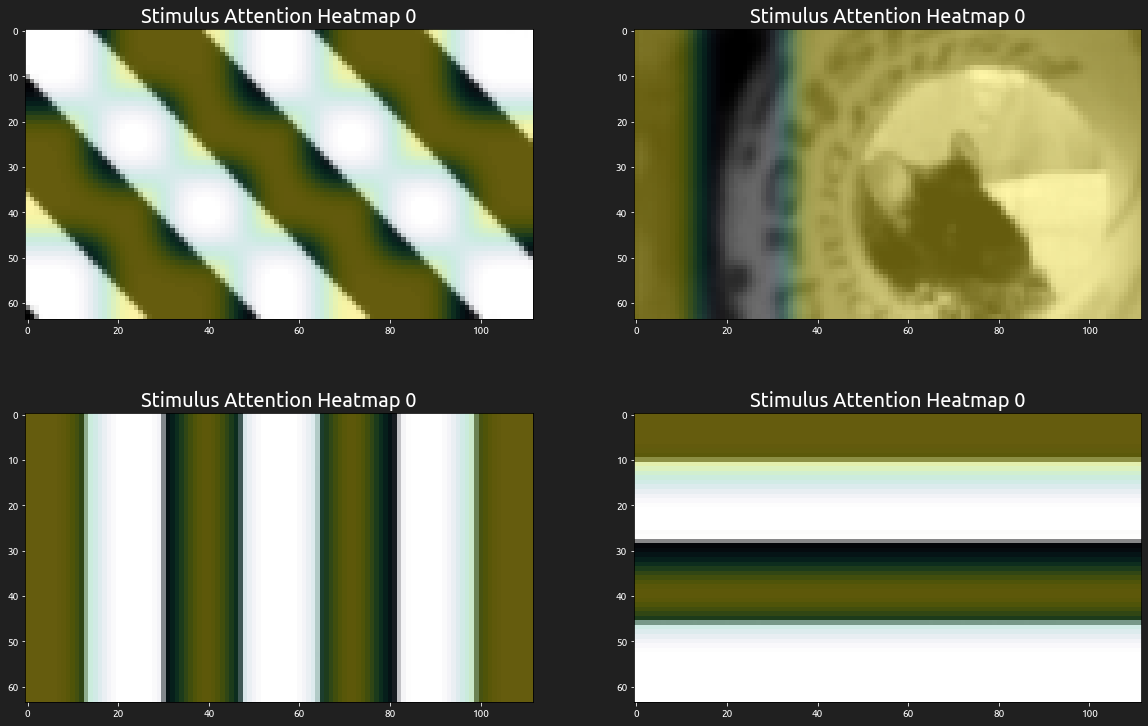

In [49]:
from utils import set_plot_white, set_plot_black
set_plot_black()
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
from scipy.special import softmax

ix_step = [171, 197, 65, 217]
ncol = 2
nrow = len(ix_step) // ncol + 1
plt.figure(figsize=(20, 20))

sorted_att_std = np.unravel_index(np.argsort(-att_trials_id_std.ravel()), att_trials_id_std.shape)
row, col = sorted_att_std
for n, ix in enumerate(ix_step):
    top_n = ix
    att_std_idx = row[(top_n - 1)], col[(top_n - 1)]
    att_top_std = att_trials_id[att_std_idx]
    att_top_std = F.softmax(torch.tensor(att_top_std), dim=-1).numpy()
    att_top_std_im = att_top_std.reshape(1, 20, 4, 7)
    att_top_std_im = att_top_std_im[-1, -1, :, :]

    t = df.groupby(['Interval', 'Trial']).size().reset_index().iloc[att_std_idx[0]]
    if t['Trial'] <= 20: n_stim = 0
    elif t['Trial'] <= 40: n_stim = 1
    elif t['Trial'] <= 60: n_stim = 2  

    im_interval = vid_stack[n_stim, math.ceil(t['Interval'] * 20)]

    att_grid =  softmax((att_top_std_im / att_top_std_im.max())**1000)
    att_grid = np.repeat(att_grid, (128 // 8), axis=0)
    att_grid = np.repeat(att_grid, (128 // 8), axis=1)

    plt.subplot(nrow, ncol, n+1)
    # im_interval = gaussian_filter(im_interval, sigma=1)
    plt.imshow(im_interval, cmap='gray')
    heatmap2d(att_grid, alpha=0.4)
    plt.title(f'Stimulus Attention Heatmap {i}', fontsize=20)




#### Our vit-style video encoder with spatio-temporal embeddings seems to capture interesting attention maps. I find this especially cool since the model is randomly initialized and trained end-to-end on pure neural data! :D